# Temperature evaluation for a single atom in tweezer using ToF approach

In [1]:
import os
import importlib


working_directory = "D:/PhD_Trieste/Simulations/Imaging_Simulation"

if os.getcwd()!= working_directory:
    os.chdir(working_directory)  
    
print(working_directory)

import Simulations_Libraries.trajectory_library as trajlib
import numpy as np
import matplotlib.pyplot as plt
from Camera import *
from scipy.stats import poisson
from scipy.optimize import curve_fit
import Simulations_Libraries.general_library as genlib
import ArQuS_analysis_lib as anslib
import matplotlib.cm as cm
from tqdm import tqdm


%matplotlib

plt.ion()

D:/PhD_Trieste/Simulations/Imaging_Simulation
Using matplotlib backend: module://matplotlib_inline.backend_inline


D:\Anaconda\envs\Imaging_Simulation\Lib\site-packages\numba\core\decorators.py:248: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [30]:
'''------------------------------Parameters-------------------------------------'''
trapType = 'Tweezer'
trapFreq_r = 2*np.pi*140e3
isotope = 171 
baseAtom = trajlib.Ytterbium(0,0,0, 0,0,0,isotope=isotope)
trapDuration = 0e-6
freeFlightTime = np.array([20,30,40,50])*1e-6
acquisitionDuration = 7e-6
experimentDuration = trapDuration + freeFlightTime
imagingOption = 'FS'
nOfAtoms = 1
initialT = 20e-6

In [31]:

meanImages = []


for j in tqdm(range(len(freeFlightTime)), desc="Loading Data",mininterval=1,maxinterval=30):
    
    '''-------------------------------folders and files------------------------------'''
    extraWord = f'_Temperature_{np.round(initialT*1e6)}uK'
    pictureFolder = working_directory +  f"/simulationImages/{trapType}/Yt{isotope}_{int(np.round(experimentDuration[j]*1e6))}us_{trapType}Duration{trapDuration*1e6}us_freeFlight{np.round(freeFlightTime[j]*1e6)}us_imagingTime{acquisitionDuration*1e6}us_imaging{imagingOption}_{nOfAtoms}" + extraWord
    simulationFolder = working_directory + f"/simulationImages/{trapType}/Yt{isotope}_{int(np.round(experimentDuration[j]*1e6))}us_{trapType}Duration{trapDuration*1e6}us_freeFlight{np.round(freeFlightTime[j]*1e6)}us_imagingTime{acquisitionDuration*1e6}us_imaging{imagingOption}_{nOfAtoms}" + extraWord + "/simulation/"
    baseFileName = "simulation"
    blurFolder = "bigBlurs/"       # PSF along the camera axis
    backgroundNoiseFolder = "Orca_testing/shots_free_space/"
    repeat = 0
    stop = False

    meanImage = np.zeros([108,108])
    
    while not stop:
        fileName = f"{baseFileName}_{repeat}.h5"
        imageFileName = f"{pictureFolder}/{fileName}"
        simulationFileName = f"{simulationFolder}/{fileName}"
        if not os.path.exists(simulationFileName):
            stop = True
        else:
            repeat +=1

            meanImage[:,:] += load_h5_image(path = imageFileName, internalPath = None, returnMetadata = False)

    meanImages.append(meanImage/repeat) 
           

Loading Data: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [05:01<00:00, 75.28s/it]


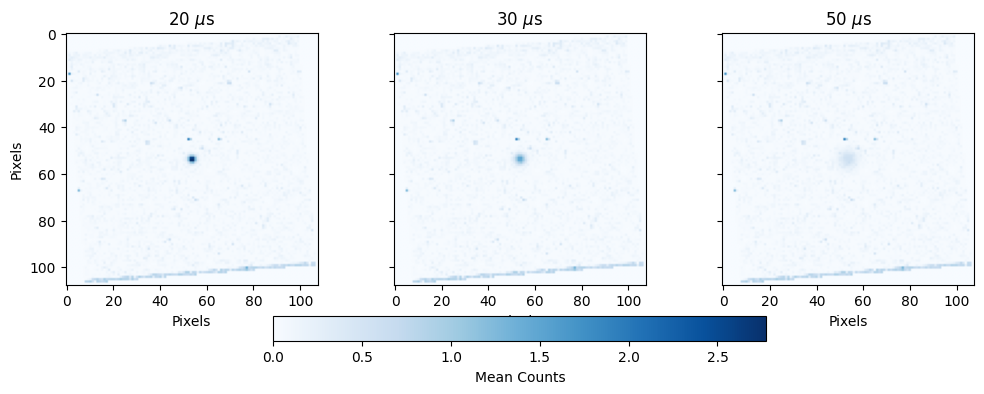

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Determine common color scale
vmin = min(meanImages[0].min(), meanImages[1].min(), meanImages[3].min())
vmax = max(meanImages[0].max(), meanImages[1].max(), meanImages[3].max())

cmap = 'Blues'
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

# --- First image ---
im0 = axs[0].imshow(meanImages[0], vmin=vmin, vmax=vmax, cmap = cmap)
axs[0].set_title(r"20 $\mu$s")
axs[0].set_xlabel("Pixels")
axs[0].set_ylabel("Pixels")

# --- Second image ---
im1 = axs[1].imshow(meanImages[1], vmin=vmin, vmax=vmax, cmap = cmap)
axs[1].set_title(r"30 $\mu$s")
axs[1].set_xlabel("Pixels")

# --- Third image ---
im2 = axs[2].imshow(meanImages[3], vmin=vmin, vmax=vmax, cmap = cmap)
axs[2].set_title(r"50 $\mu$s")
axs[2].set_xlabel("Pixels")

# --- Shared colorbar (bottom) ---
cbar = fig.colorbar(
    im2,
    ax=axs,
    orientation="horizontal",
    fraction=0.08,
    pad=0.20,
    cmap = cmap
)
cbar.set_label("Mean Counts")

# 🔑 Reserve space for the colorbar
plt.subplots_adjust(bottom=0.25)

plt.show()



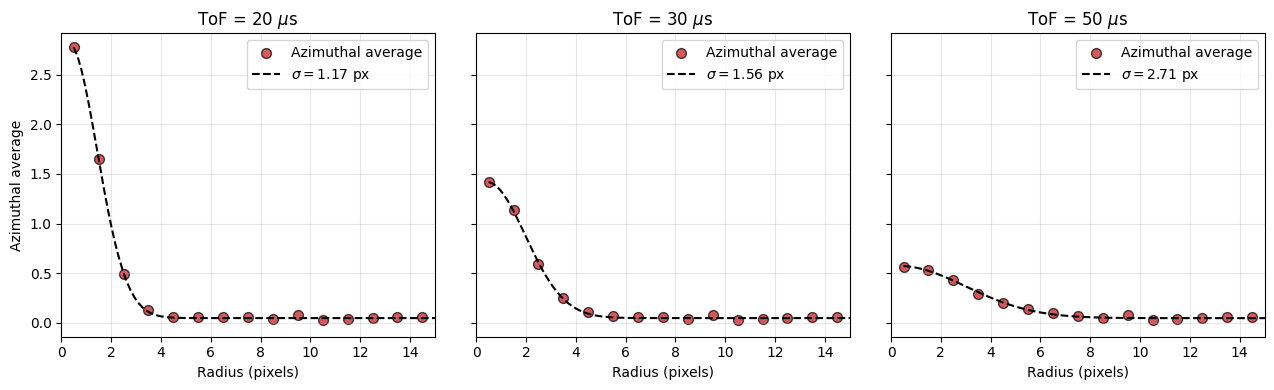

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

indices = np.array([0, 1, 3])
centers = np.ones([2, len(freeFlightTime)]) * 54

# --- Azimuthal average function ---
def azimuthal_average(image, center=None, bin_size=1):
    ny, nx = image.shape
    if center is None:
        center = (nx // 2, ny // 2)

    x0, y0 = center
    y, x = np.indices(image.shape)
    r = np.sqrt((x - x0)**2 + (y - y0)**2)

    r_bin = (r / bin_size).astype(int)
    radial_sum = np.bincount(r_bin.ravel(), image.ravel())
    radial_count = np.bincount(r_bin.ravel())

    radial_mean = radial_sum / radial_count
    r_values = (np.arange(len(radial_mean)) + 0.5) * bin_size

    return r_values, radial_mean


# --- Gaussian model ---
def gaussian(r, A, r0, sigma, C):
    return A * np.exp(-(r - r0)**2 / (2 * sigma**2)) + C


# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

for ax, idx in zip(axes, indices):

    r, profile = azimuthal_average(
        meanImages[int(idx)],
        center=tuple(centers[:, idx])
    )

    # Initial guesses
    A0 = profile.max() - profile.min()
    r0_0 = r[np.argmax(profile)]
    sigma0 = r.max() / 10
    C0 = profile.min()
    p0 = [A0, r0_0, sigma0, C0]

    # Fit
    popt, _ = curve_fit(gaussian, r, profile, p0=p0)
    A, r0, sigma, C = popt

    # Fit curve
    r_fit = np.linspace(r.min(), r.max(), 500)
    profile_fit = gaussian(r_fit, *popt)

    # Plot
    ax.scatter(r, profile, s=50, label="Azimuthal average",color = cm.Reds(0.8),edgecolor = 'black',alpha = 0.7)
    ax.plot(r_fit, profile_fit, '--', label=fr"$\sigma={sigma:.2f}$ px",color = 'black')
    ax.set_xlim(0, 15)
    ax.set_xlabel("Radius (pixels)")
    ax.set_title(f"ToF = {int((idx+2) * 10)} $\mu$s")
    ax.grid(alpha=0.3)
    ax.legend()

axes[0].set_ylabel("Azimuthal average")

plt.tight_layout()
plt.show()


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

sigmaPixels = []
errorSigmaPixels = []
# --- Azimuthal average function (must already exist) ---
def azimuthal_average(image, center=None, bin_size=1):
    ny, nx = image.shape
    if center is None:
        center = (nx // 2, ny // 2)

    x0, y0 = center
    y, x = np.indices(image.shape)
    r = np.sqrt((x - x0)**2 + (y - y0)**2)

    r_bin = (r / bin_size).astype(int)
    radial_sum = np.bincount(r_bin.ravel(), image.ravel())
    radial_count = np.bincount(r_bin.ravel())

    radial_mean = radial_sum / radial_count
    r_values = (np.arange(len(radial_mean)) + 0.5) * bin_size

    return r_values, radial_mean


# --- Gaussian model ---
def gaussian(r, A, r0, sigma, C):
    return A * np.exp(-(r - r0)**2 / (2 * sigma**2)) + C

pixelSize = 4.6e-6
magnification = 8
conversionFactor = pixelSize/magnification

# --- Data ---
for i in range(len(freeFlightTime)):
    
    r, profile = azimuthal_average(meanImages[i], center=tuple(centers[:,i]))
    
    # --- Initial guesses ---
    A0 = profile.max() - profile.min()
    r0_0 = r[np.argmax(profile)]
    sigma0 = r.max() / 10
    C0 = profile.min()
    
    p0 = [A0, r0_0, sigma0, C0]
    
    # --- Fit ---
    popt, pcov = curve_fit(gaussian, r, profile, p0=p0)
    
    A, r0, sigma, C = popt
    errorSigma = np.sqrt(pcov[2][2])
    
    sigmaPixels.append(sigma)
    errorSigmaPixels.append(errorSigma)




sigmaPixels = np.asarray(sigmaPixels)
errorSigmaPixels = np.asarray(errorSigmaPixels)
sigmaUM = sigmaPixels * conversionFactor
errorSigmaUM = errorSigmaPixels * conversionFactor 


In [79]:
import numpy as np
from scipy.optimize import curve_fit

'''
def TOF_fit(t, T, offset):
    return np.sqrt(trajlib.kB * T / baseAtom.m)*np.sqrt(t**2 + offset)
'''


def TOF_fit(t, T):
    return np.sqrt(trajlib.kB * T / baseAtom.m)*np.sqrt( t**2  + 1/(trapFreq_r**2))
'''
def TOF_fit(t, T, offset):
    return np.sqrt(trajlib.kB * T / baseAtom.m)*t + offset
'''
# data arrays
t = freeFlightTime      # x data
y = sigmaUM               # y data
y_err = errorSigmaUM      # absolute error on y

# initial guesses for parameters [T, offset]
p0 = [initialT] #, 0.0]          # example: T in K, offset in same units as sigmaUM

# curve fitting
popt, pcov = curve_fit(
    TOF_fit,
    t,
    y,
    sigma=y_err,
    absolute_sigma=True,
    p0=p0
)

# fitted parameters
T_fit = popt#, offset_fit = popt

# 1-sigma uncertainties
perr = np.sqrt(np.diag(pcov))
T_err = perr#, offset_err = perr




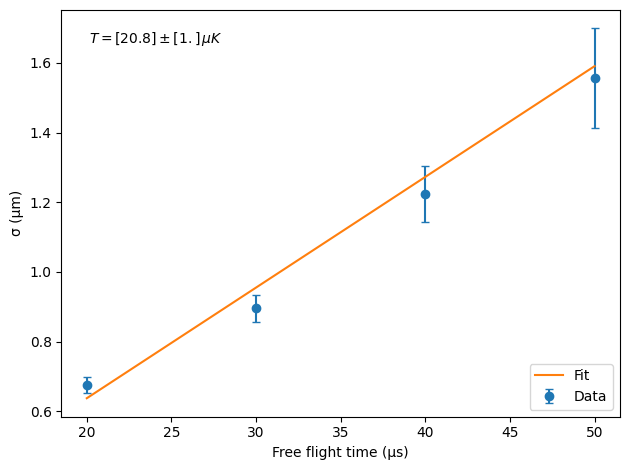

In [92]:
# ----- Plot data vs fitted curve -----

# smooth time axis for fitted curve
t_fit = np.linspace(np.min(t), np.max(t), 500)
y_fit = TOF_fit(t_fit, T_fit)#, offset_fit)

plt.figure()
plt.errorbar(
    t*1e6,
    y*1e6,
    yerr=y_err*1e6,
    fmt='o',
    label='Data',
    capsize=3
)
plt.plot(
    t_fit*1e6,
    y_fit*1e6,
    label='Fit'
)

plt.xlabel("Free flight time (µs)")
plt.ylabel("σ (µm)")
plt.legend()

# --- Add temperature text on plot ---
T_text = rf"$T = {np.round(T_fit*1e6,1)} \pm {np.round(T_err*1e6,1)}\,\mu K$"
plt.text(
    0.05, 0.95,          # position in axes coordinates
    T_text,
    transform=plt.gca().transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()
